##  Construir una red bayesianna a partir del conocimiento experto


## Description:
__Context:__
Predict next-day rain by training classification models on the target variable RainTomorrow.

__Content:__
This dataset contains about 10 years of daily weather observations from many locations across Australia.


__RainTomorrow__ is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

Source & Acknowledgements
Observations were drawn from numerous weather stations. The daily observations are available from [link](http://www.bom.gov.au/climate/data).
An example of latest weather observations in Canberra:[link](http://www.bom.gov.au/climate/dwo/IDCJDW2801.latest.shtml)

Definitions adapted from http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml
Data source:[source](http://www.bom.gov.au/climate/dwo/ and http://www.bom.gov.au/climate/data).

Copyright Commonwealth of Australia 2010, Bureau of Meteorology.

### Lib
- pybb(is a Python implementation of probabilistic and causal inference in Bayesian Belief Networks)
- pandas
- networkx para dibujar el grafo

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
## crear grafo aciclico dirigido
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController


In [2]:
df=pd.read_csv("weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [24]:
df.shape

(145460, 23)

Para trabajar con redes bayesianas necesitamos variables descretizadas.
- Aqui en este caso abajo vemos que la tempeatura tiene 505 valores o hallazgo lo que complica mucho el calculo


In [4]:
df['MaxTemp'].value_counts()

 20.0    885
 19.0    843
 19.8    840
 20.4    834
 19.9    823
        ... 
 46.5      1
 46.9      1
 47.0      1
 46.6      1
-2.4       1
Name: MaxTemp, Length: 505, dtype: int64

In [5]:
print(df['MaxTemp'].min())
print(df['MaxTemp'].max())
print(df['MaxTemp'].mean())

-4.8
48.1
23.22134827564685


In [7]:
# se reduce en 3 valores en vez de 505
pd.cut(df['MaxTemp'],bins=3,labels=['-4.8-12.8','12.8-30','30.4-48'])

0         12.8-30
1         12.8-30
2         12.8-30
3         12.8-30
4         30.4-48
           ...   
145455    12.8-30
145456    12.8-30
145457    12.8-30
145458    12.8-30
145459        NaN
Name: MaxTemp, Length: 145460, dtype: category
Categories (3, object): ['-4.8-12.8' < '12.8-30' < '30.4-48']

In [3]:
#mramos el porcentaje de valores nulos en df

copy=(df.isnull().sum()/df.shape[0]).to_frame().rename(columns={0:"Por_nulos"})


In [4]:
copy

,Por_nulos
Date,0.000000
Location,0.000000
MinTemp,0.010209
MaxTemp,0.008669
Rainfall,0.022419
Evaporation,0.431665
Sunshine,0.480098
WindGustDir,0.070989
WindGustSpeed,0.070555
WindDir9am,0.072639


In [5]:
#filtramos los var nulos menores 25% 
lista=list(copy[copy["Por_nulos"]<0.25].index)
lista

['Date',
 'Location',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RainTomorrow']

In [6]:
#pasamos la lista con el porcetage <25% no valores nulos
df=df[lista]

In [9]:
df.shape

(142193, 19)

In [8]:
#quitamos los nulos de la target
df=df[~df['RainTomorrow'].isnull()]

In [10]:
#quitamos los valores mumericos nulos con la media,
#en caso de cat var habra que usar la moda 
#Aqui no se trata de profundizar los methodos de limpieza de datos mas bien el objetivo es 
#contruir red bayesiana
df.fillna(df.mean(),inplace=True)

C:\Users\loli\AppData\Local\Temp\ipykernel_4172\3968678937.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.mean(),inplace=True)


Pensamos que para que se produzca la lluvia habra estos factores causales
MinTemp,windSpeed3pm/9pm,humidity3pm,Humidity9am.
Miramos la informacion mutua de la varibales respecto a la target



- La información mutua es una buena alternativa al coeficiente de correlación de Pearson, ya que es capaz de medir cualquier tipo de relación entre variables, no solo asociaciones lineales. Y además, es adecuado tanto para variables continuas como discretas, a diferencia del coeficiente de correlación de Pearson.

In [11]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression


In [18]:
#info mutua entre dos variables continuas 
mutual_info_regression(df['MinTemp'].to_frame(),df['Humidity9am'],discrete_features=[False])

array([0.0631118])

In [26]:
mutual_info_classif(df['WindGustSpeed'].to_frame(),df['RainTomorrow'],discrete_features=[False])

array([0.02606145])

In [27]:
mutual_info_classif(df['WindSpeed9am'].to_frame(),df['RainTomorrow'],discrete_features=[False])

array([0.00480041])

In [28]:
mutual_info_classif(df['Humidity3pm'].to_frame(),df['RainTomorrow'],discrete_features=[False])

array([0.11368368])

In [29]:
mutual_info_regression(df['Humidity9am'].to_frame(),df['Humidity3pm'],discrete_features=[False])

array([0.35851658])

In [31]:
mutual_info_regression(df['WindGustSpeed'].to_frame(),df['Humidity9am'],discrete_features=[False])

array([0.05605038])

In [82]:
mutual_info_regression(df['WindGustSpeed'].to_frame(),df['MinTemp'],discrete_features=[False])

array([0.05236796])

In [32]:
lista2=['MinTemp','WindGustSpeed','Humidity9am','Humidity3pm','RainTomorrow']

In [33]:
cp=df[lista2]

In [34]:
#we have 22% de prob que llueva
cp.RainTomorrow.value_counts()/cp.shape[0]

No     0.775819
Yes    0.224181
Name: RainTomorrow, dtype: float64

In [42]:
cp['Humidity3pmcat']=pd.cut(cp.Humidity3pm,bins=2,labels=['h<=50','h>50'])#.value_counts(normalize=True)



C:\Users\loli\AppData\Local\Temp\ipykernel_4172\1540304492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp['Humidity3pmcat']=pd.cut(cp.Humidity3pm,bins=2,labels=['h<=50','h>50'])#.value_counts(normalize=True)


<AxesSubplot: xlabel='Humidity3pmcat', ylabel='count'>

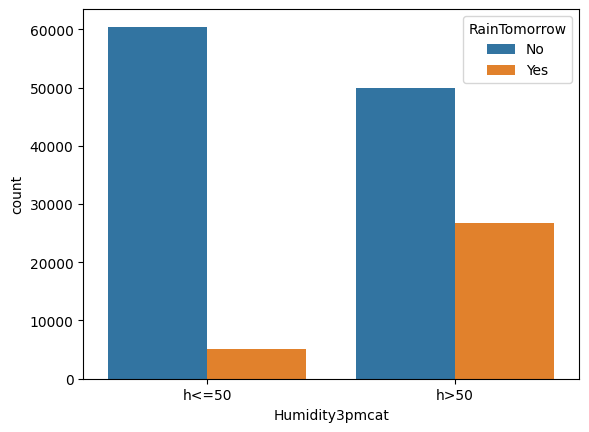

In [44]:
#we havemore chance when humidity is high
import seaborn as sns
sns.countplot(x=cp.Humidity3pmcat,hue=cp.RainTomorrow)

In [52]:
cp['Humidity9amcat']=pd.cut(cp['Humidity9am'],bins=2,labels=['h9a<=50','h9a>50'])

C:\Users\loli\AppData\Local\Temp\ipykernel_4172\2927624468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp['Humidity9amcat']=pd.cut(cp['Humidity9am'],bins=2,labels=['h9a<=50','h9a>50'])


<AxesSubplot: xlabel='Humidity9amcat', ylabel='count'>

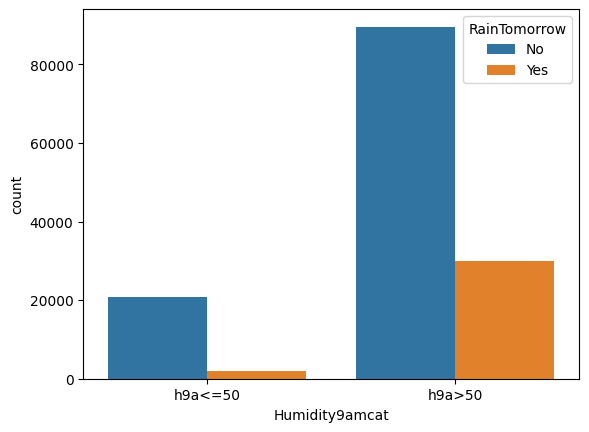

In [53]:
sns.countplot(x=cp.Humidity9amcat,hue=cp.RainTomorrow)

In [65]:

pd.cut(cp['WindGustSpeed'],bins=4).value_counts().sort_index()

(5.871, 38.25]     65484
(38.25, 70.5]      72948
(70.5, 102.75]      3669
(102.75, 135.0]       92
Name: WindGustSpeed, dtype: int64

In [67]:
bins = pd.IntervalIndex.from_tuples([(5.871, 39), (39, 71), (71, 135)])
cp['WindGustSpeedcat']=pd.cut(cp['WindGustSpeed'],bins=bins,labels=['W<=39','39<W<=71','W>71'])

C:\Users\loli\AppData\Local\Temp\ipykernel_4172\350633633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp['WindGustSpeedcat']=pd.cut(cp['WindGustSpeed'],bins=bins,labels=['W<=39','39<W<=71','W>71'])


<AxesSubplot: xlabel='WindGustSpeedcat', ylabel='count'>

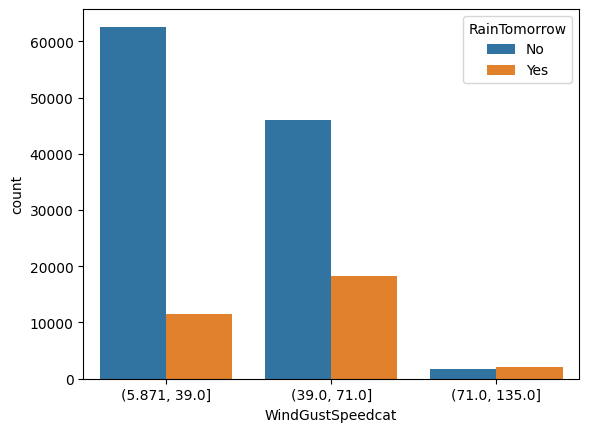

In [69]:
sns.countplot(x=cp.WindGustSpeedcat,hue=cp.RainTomorrow)

In [72]:
pd.cut(cp.MinTemp,bins=2,).value_counts(normalize=True)#labels=['temp<=12.7','12.7<temp<33.9'])

(-8.542, 12.7]    0.544394
(12.7, 33.9]      0.455606
Name: MinTemp, dtype: float64

In [74]:
cp['MinTempcat']=pd.cut(cp.MinTemp,bins=2,labels=['T<=12.7','T>12.7'])

C:\Users\loli\AppData\Local\Temp\ipykernel_4172\1929450297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp['MinTempcat']=pd.cut(cp.MinTemp,bins=2,labels=['T<=12.7','T>12.7'])


<AxesSubplot: xlabel='MinTempcat', ylabel='count'>

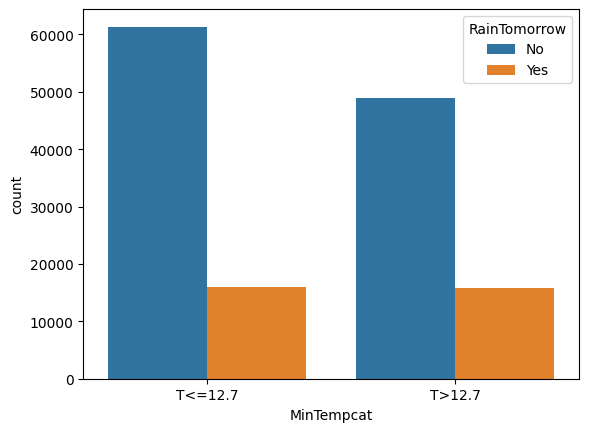

In [75]:
sns.countplot(x=cp.MinTempcat,hue=cp.RainTomorrow)

In [76]:
#cp.isnull().sum()
cp.to_csv('new_format.csv')

## Setting up Bayesian Belief Network


### Vamos a calcular las probabilidades marginales

In [77]:
 cp.WindGustSpeedcat.value_counts(normalize=True)

(5.871, 39.0]    0.521404
(39.0, 71.0]     0.452146
(71.0, 135.0]    0.026450
Name: WindGustSpeedcat, dtype: float64

In [78]:
cp.Humidity3pmcat.value_counts(normalize=True)

h>50     0.538803
h<=50    0.461197
Name: Humidity3pmcat, dtype: float64

In [79]:
cp.Humidity9amcat.value_counts(normalize=True)

h9a>50     0.84092
h9a<=50    0.15908
Name: Humidity9amcat, dtype: float64

In [80]:
cp.MinTempcat.value_counts(normalize=True)

T<=12.7    0.544394
T>12.7     0.455606
Name: MinTempcat, dtype: float64

In [81]:
cp.RainTomorrow.value_counts(normalize=True)

No     0.775819
Yes    0.224181
Name: RainTomorrow, dtype: float64

DAG IS LOOK LIKE :CUASAL
    
  MinTempcat->Humidity9amcat->Humidity3pmcat->RainTomorrow
   MinTempcat->WindSpeed9amcat->RainTomorrow
   

- Ahora hay que calcular las probabilad P(H|D)=P(D|H)P(H)P(D)
- Una forma sencilla es utilizar pandas corsstable

In [85]:
pd.crosstab(cp['MinTempcat'],cp['Humidity9amcat'], margins=False,normalize='index' ).sort_index()

Humidity9amcat,h9a<=50,h9a>50
MinTempcat,,
T<=12.7,0.124197,0.875803
T>12.7,0.200759,0.799241


In [92]:
# CALCULAR P(HUMI3AMCAT|HUMI9AMCAT)
#

#By default, computes a frequency table of the factors unless an
#array of values and an aggregation function are passed.
pd.crosstab(cp['Humidity9amcat'],cp['Humidity3pmcat'], margins=False,normalize='index' )

Humidity3pmcat,h<=50,h>50
Humidity9amcat,,
h9a<=50,0.903404,0.096596
h9a>50,0.377543,0.622457


In [86]:
pd.crosstab([cp['Humidity3pmcat'],cp['WindGustSpeedcat']],cp['RainTomorrow'] ,margins=False,normalize='index' )#.sort_index().to_numpy().reshape(-1).tolist()

RainTomorrow                           No       Yes
Humidity3pmcat WindGustSpeedcat                    
h<=50          (5.871, 39.0]     0.956692  0.043308
               (39.0, 71.0]      0.894021  0.105979
               (71.0, 135.0]     0.698830  0.301170
h>50           (5.871, 39.0]     0.747271  0.252729
               (39.0, 71.0]      0.563856  0.436144
               (71.0, 135.0]     0.258898  0.741102

In [87]:
#Esta funcion nos ayuda a calcualr la probabilidad condicionada
def probCond(df,hijo,padre1=None,padre2=None):
    #no tiene padre o es raiz
    if(padre1==None):
        prob=pd.crosstab(df[hijo],'Empty',normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif padre1!=None:
            if padre2==None :
                        prob=pd.crosstab(df[padre1],df[hijo],normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:
                        prob=pd.crosstab([df[padre1],df[padre2]],df[hijo],normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else:
        print("hay un error en precesar el calculo ")
    return prob       

In [89]:
p=probCond(cp,hijo='RainTomorrow',padre1='Humidity3pmcat',padre2='WindGustSpeedcat')
p

[0.956692455354546,
 0.04330754464545402,
 0.894021094041442,
 0.10597890595855801,
 0.6988304093567251,
 0.30116959064327486,
 0.7472709894863927,
 0.2527290105136073,
 0.5638557678494469,
 0.4361442321505531,
 0.25889809848854217,
 0.7411019015114578]

In [98]:
cp.WindGustSpeedcat.value_counts()

(5.871, 39.0]    74140
(39.0, 71.0]     64292
(71.0, 135.0]     3761
Name: WindGustSpeedcat, dtype: int64

In [143]:
#construir la red beyesiana
T=  BbnNode(Variable(0, 'MinTemp',['T<=12.7' , 'T>12.7']), probCond(cp,hijo='MinTempcat'))
X = BbnNode(Variable(1, 'H9amcat', ['h9a<=50' , 'h9a>50']), probCond(cp,hijo='Humidity9amcat',padre1='MinTempcat'))
Y = BbnNode(Variable(2, 'H3pmcat', ['h<=50' , 'h>50']),probCond(cp,hijo='Humidity3pmcat',padre1='Humidity9amcat'))

Z = BbnNode(Variable(3, 'wind', ['(5.871, 39.0]' , '(39.0, 71.0]' , '(71.0, 135.0]']),probCond(cp,hijo='WindGustSpeedcat',padre1='MinTempcat'))
V=  BbnNode(Variable(4, 'Rain', ['No', 'Yes']),probCond(cp,hijo='RainTomorrow',padre1='WindGustSpeedcat',padre2='Humidity3pmcat'))

# create the network structure
bbn = Bbn() \
    .add_node(T) \
    .add_node(X) \
    .add_node(Y) \
    .add_node(Z) \
    .add_node(V) \
    .add_edge(Edge(T, X, EdgeType.DIRECTED)) \
    .add_edge(Edge(X, Y, EdgeType.DIRECTED)) \
    .add_edge(Edge(Y, V, EdgeType.DIRECTED)) \
    .add_edge(Edge(T, Z, EdgeType.DIRECTED)) \
    .add_edge(Edge(Z, V, EdgeType.DIRECTED)) 
# convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

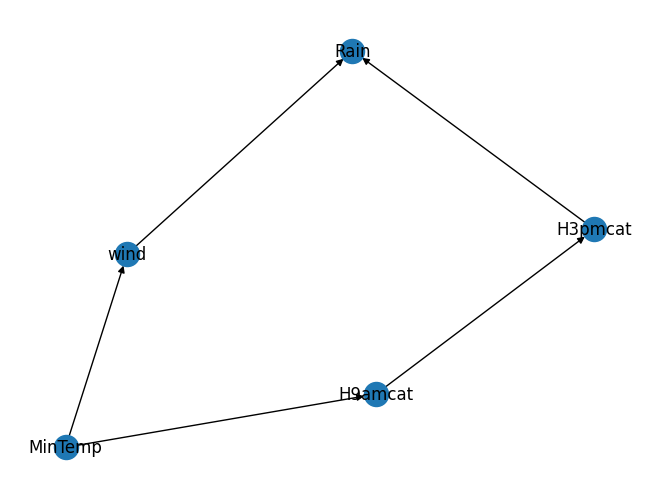

In [149]:
#dibujar el grafo
import numpy as np

from pybbn.generator.bbngenerator import convert_for_drawing
n, d = bbn.to_nx_graph()
nx.draw(nx_graph,with_labels=True,labels=d)

In [150]:
# print the  probabilities for each node
for node in join_tree.get_bbn_nodes():
    print("Node:", node)
    print("Values:") 
    print(join_tree.get_bbn_potential(node))

Node: 2|H3pmcat|h<=50,h>50
Values:
2=h<=50|0.46120
2=h>50|0.53880
Node: 3|wind|(5.871, 39.0],(39.0, 71.0],(71.0, 135.0]
Values:
3=(5.871, 39.0]|0.52140
3=(39.0, 71.0]|0.45215
3=(71.0, 135.0]|0.02645
Node: 4|Rain|No,Yes
Values:
4=No|0.72876
4=Yes|0.27124
Node: 0|MinTemp|T<=12.7,T>12.7
Values:
0=T<=12.7|0.54439
0=T>12.7|0.45561
Node: 1|H9amcat|h9a<=50,h9a>50
Values:
1=h9a<=50|0.15908
1=h9a>50|0.84092


Con esa configuracion tenemos la prob que lleva es 27% es un poco mejor de la original 22%

### vamos a crear una evidencia y vemos como afecta a la red 
por ejemplo nodo 0 E={H9amcat=h9a>50,wind='(39.0, 71.0]'}

In [159]:
#ANTES CREAMOS UNA FUNCION QUE IMPRIMA LA PROBABILIDADES DE LOS NODOS
def print_prob():
    for node in join_tree.get_bbn_nodes():
        print("Node:", node)
        print("Values:") 
        print(join_tree.get_bbn_potential(node))
 

In [152]:
def print_prob2():
    for node, posteriors in join_tree.get_posteriors().items():
        p = ', '.join([f'{val}={prob:.5f}' for val, prob in posteriors.items()])
        print(f'{node} : {p}')

In [155]:
# insert an observation evidence
#cat=categoria
#por=porcentaje
def evidencia(n_ev,nodo,cat,por):
    n_ev = EvidenceBuilder() \
            .with_node(join_tree.get_bbn_node_by_name(nodo)) \
            .with_evidence(cat, por) \
            .build()
    join_tree.set_observation(n_ev)


In [164]:
evidencia('ev5','MinTemp','T<=12.7',1.0)
#evidencia('ev7','H9amcat','h9a>50',1.0)
evidencia('ev6','wind','(71.0, 135.0]',1.0)
#evidencia('ev3','wind3pm','W>43',1.0)

print_prob()

Node: 2|H3pmcat|h<=50,h>50
Values:
2=h<=50|0.37754
2=h>50|0.62246
Node: 3|wind|(5.871, 39.0],(39.0, 71.0],(71.0, 135.0]
Values:
3=(5.871, 39.0]|0.00000
3=(39.0, 71.0]|0.00000
3=(71.0, 135.0]|1.00000
Node: 4|Rain|No,Yes
Values:
4=No|0.49868
4=Yes|0.50132
Node: 0|MinTemp|T<=12.7,T>12.7
Values:
0=T<=12.7|0.57947
0=T>12.7|0.42053
Node: 1|H9amcat|h9a<=50,h9a>50
Values:
1=h9a<=50|0.00000
1=h9a>50|1.00000
